# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [1]:
# You might want to use the following package
"""sources: https://www.cs.virginia.edu/~nn4pj/teaching, https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch09.html#idm45022159899512,
https://stackoverflow.com/questions/61181342/how-to-graph-centroids-with-kmeans, https://www.kaggle.com/andyxie/k-means-clustering-implementation-in-python,
https://newbedev.com/numpy/reference/random/generated/numpy.random.generator.choice"""

from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Your code goes here for this section.

In [2]:
import pandas as pd

housing = pd.read_csv("/content/california_housing.csv")

In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]



In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=False)),
        ('std_scaler', StandardScaler()),
    ])

In [6]:
from sklearn.compose import ColumnTransformer
import numpy as np


housing_num = housing.select_dtypes(include=[np.number])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [7]:
housing_prepared.shape

(20640, 16)

In [8]:
housing_prepared[:1]

array([[-1.32783522,  1.05254828,  0.98214266, -0.8048191 , -0.97247648,
        -0.9744286 , -0.97703285,  2.34476576,  2.12963148,  0.62855945,
        -0.04959654,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ]])

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [9]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).


In [10]:
from copy import deepcopy

def initialize_centroids(data, k):
  examples, features = data.shape
  std = np.std(data, axis=0)
  mean = np.mean(data, axis=0)
  #return np.random.randn(k, features)*std + mean
  rng = np.random.default_rng()
  return rng.choice(data,k)
def find_distance(data, method,centroids,k):
  distance = np.zeros((data.shape[0],k))
  if method == "manhattan":
    for x in range(k):
        distance[:,x] = np.sum((data - centroids[x]), axis=1)
    return distance
  elif method == "euclidean":
      for x in range(k):
          distance[:,x] = np.sqrt(np.sum(((data - centroids[x])**2), axis=1))
      return distance
  elif method == "sup":
      for x in range(k):
          distance[:,x] = np.sum(np.maximum(data,centroids[x]), axis=1)
      return distance
  else:
        print("Method input must be 'manhattan', 'euclidean', or 'sup'")
        exit()

def kmeans(data,k, method):
  centroids = initialize_centroids(data,k)
  old_error = 1 
  error = np.zeros(k)
  total_error = 0
  while old_error != total_error:
    old_error = total_error
    distances = find_distance(data,method,centroids,k)
    clusters = np.argmin(distances, axis=1)
    for x in range(k):
      centroids[x] = np.mean(data[clusters == x], axis=0)
    for x in range(k):
      error[x] = sum(np.sum(((data[clusters == x]-centroids[x])**2),axis=1))
    total_error = sum(error)
  return total_error, centroids, clusters



In [11]:
print(kmeans(housing_prepared,3,"euclidean")[0]) #euclidean seems to have lowest inertia/sse
print(kmeans(housing_prepared,3,"manhattan")[0])
print(kmeans(housing_prepared,3,"sup")[0])

163316.01654266383
240960.4657945739
202970.68055715176


- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


In [12]:
# Your code goes here
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def cluster_std_mean(clusters,data,k):
  means = np.zeros((k,data.shape[1]))
  stds = np.zeros((k,data.shape[1]))
  for x in range(k):
      means[x] = np.mean(data[clusters == x], axis=0)
      stds[x] = np.std(data[clusters == x],axis=0)
  return means, stds

def plot_kmeans(data,k,method):
  test_error, centroids, clusters = kmeans(data,k,method)
  plt.scatter(data[:,0], data[:,1], c=None, s=1)
  plt.xlabel("$latitude$", fontsize=14)
  plt.ylabel("$longitude$", fontsize=14, rotation=0)

  for i in range(centroids.shape[0]):
    plt.text(centroids[i,0], centroids[i,1], str(i))
  
  return cluster_std_mean(clusters, data, k)



Num clusters: 2
means: [ 0.04864602 -0.06428322]
stds: [1.01372043 0.97787018]
Num clusters: 3
means: [-0.07335076  0.02693776  0.19279293]
stds: [0.9785479  1.01964885 0.94549249]
Num clusters: 4
means: [ 1.59759915 -0.31230509 -0.31329245  0.13051418]
stds: [1.15443221 0.60656017 0.64038136 0.8334453 ]
Num clusters: 5
means: [ 1.65241155 -0.32505788  0.30166528  0.00441339 -0.31219223]
stds: [1.1672868  0.6407679  0.8225963  0.76331457 0.61445776]
Num clusters: 6
means: [ 0.00286575 -0.5094761   1.74541325  0.30735372  0.11687142 -0.31291981]
stds: [0.76627342 0.5948127  1.21219487 0.82247268 0.72796433 0.60564155]
Num clusters: 7
means: [-0.31053802 -0.12910278  0.12939553 -0.54470862  0.29639261  0.08250355
  1.79623727]
stds: [0.6146077  0.68924236 0.75014375 0.58624497 0.84926684 0.73090256
 1.2261387 ]
Num clusters: 8
means: [ 0.1401155   2.55977943  0.06338555 -0.48941736  0.42981316 -0.46680129
 -0.30509374  0.87751585]
stds: [0.82241309 1.42214277 0.68697708 0.59822935 0.8426

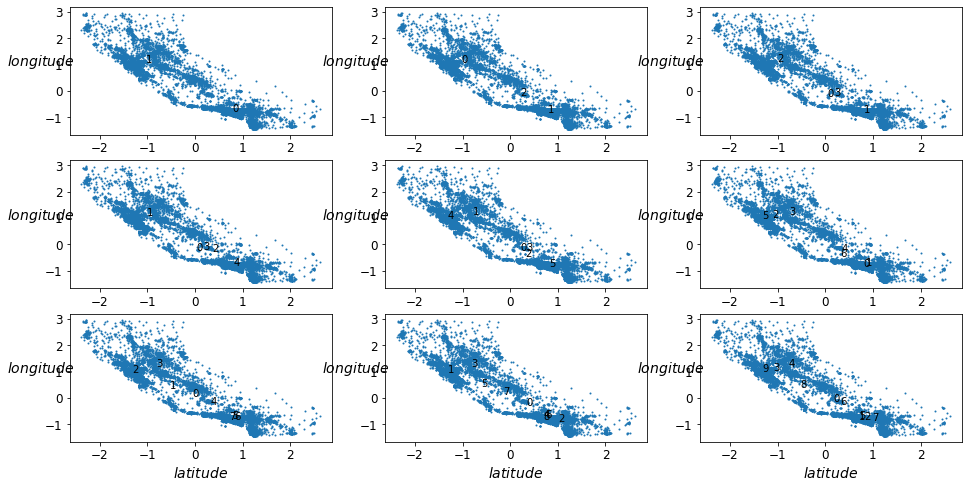

In [22]:
np.random.seed(1)
plt.figure(figsize=(16, 8))

for x in range(1,10):
  plt.subplot(3,3,x)
  print("Num clusters: "+str(x+1))
  means, stds = plot_kmeans(housing_prepared,x+1,"euclidean")
  print("means: " + str(means[:,7])) #prints out mean median income of clusters
  print("stds: " + str(stds[:,7])) 
plt.show()

Using k-means clustering, we were able to separate California into various numbers of different clusters, ranging from 2 to 10. At 2 clusters, the division was essentially northern California vs southern California. Comparing the average median income and house values within each cluster, it can be seen that northern California tends to have higher average values for both median income and home value. This makes sense, as the northern California cluster contains the prosperous Silicon Valley. Indeed, any cluster that is closer to, or contains Silicon Valley, has an higher average median income. This effect is very apparent when num_clusters = 4. Cluster 3 as marked on the upper left plot is around Silicon Valley as has by far the highest median income. 

Another interesting feature, is the gaps of plot points and clusters in certain areas. These correspond to regions heavy with mountains, deserts, or deep valleys. These areas tend to be less densely populated than the Californian coasts. Clusters that contain parts of the west coast have much higher mean population.

[0.50106176 0.46137797 0.40872853 0.27158654 0.41151826 0.41090364
 0.89224409 2.94381938 0.55172922 0.60556743]


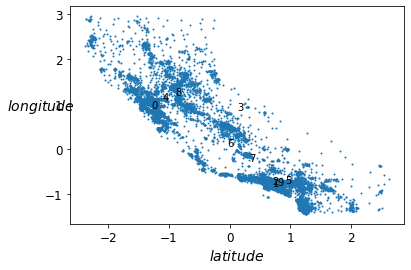

In [21]:
print(plot_kmeans(housing_prepared,x+1,"euclidean")[1][:,5]) #shows std population of clusters

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



In general, the less clusters, the less specific the information revealed. In the 2 cluster plot, the number of points belonging to each cluster is so high that the average median income for both clusters comes out to be around 0; not very helpful. In contrast, the 10 cluster plot is much more specific, with useful information from all the features. 

From the plotted clusters, it is visible that California is characterized by several clusters that are consistently densely populated. Median income and median home value tend to skyrocket at these clusters. High standard deviations for median income suggest growing wealth inequality at these clusters. Like other sectors of the economy, the housing market is based off of supply and demand. The more people pouring into Silicon Valley and other high opportunity areas of California, the more the median home value is driven up. The original residents in these areas can't keep up with the increasing housing costs, and are driven out, exacerbating the California Housing Crisis. To solve this crisis, the government can invest in programs such as quality, affordable public housing. This will increase supply and in some areas, bring housing costs down. The government could also offer housing subsidies, instead of building housing projects directly. Another solution is for more regulation of the housing market, putting a cap on how much rent can be increased in a certain time period. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!